# Image alignment

Objetivo alinhar as imagens obtidas nas 4 faixas espectrais para obter uma imagem de 4 canais que representa o objeto e pode ser visualizada como uma imagem de falsa-cor.

![image info](./alignment-visualization.png)

a ideia inicial é usar os [descriptores](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html).



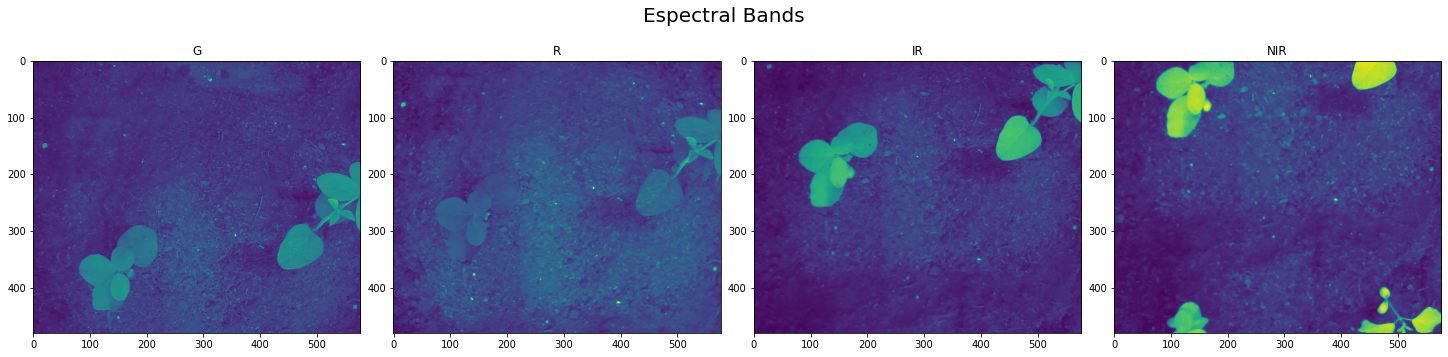

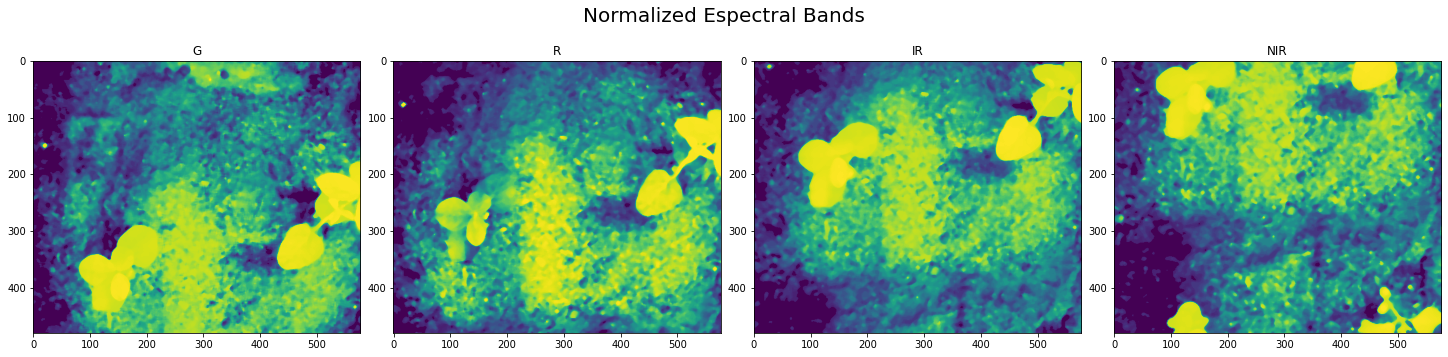

In [46]:
import cv2
import os
import numpy as np
import sys
import matplotlib.pyplot as plt


G   = cv2.imread("imgs/Soja_v3G-01-03.png",  0) 
R   = cv2.imread("imgs/Soja_v3R-01-03.png",  0)
NIR  = cv2.imread("imgs/Soja_v3IR-01-03.png", 0)
IR = cv2.imread("imgs/Soja_v3NIR-01-03.png",0)
RGB = cv2.imread("imgs/Soja_v3RGB-01-03.png")

bands = [G,R,IR,NIR]
names = ["G","R","IR","NIR"]
# Visualização das imagens
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# A normalização das imagens facilita a comparação entre as imagens destacando as plantas do backgroud
def equalize_smooth(img):
    """ Histogram Normalization and gaussian blur of input image """
    # img_blur = cv2.GaussianBlur(img, (3,3),0)
    img_blur = cv2.medianBlur(img, 7)
    img_norm = cv2.equalizeHist(img_blur)
    ret, img_norm = cv2.threshold(img_norm, 20, 255, cv2.THRESH_TOZERO)
    return img_norm

# Visualização das imagens normalizadas
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Normalized Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    img = equalize_smooth(img)
    ax.imshow(img)
    ax.set_title(name)

# RGB image for reference
# plt.show()
# plt.imshow(RGB)
# plt.title("RGB")
# plt.show()



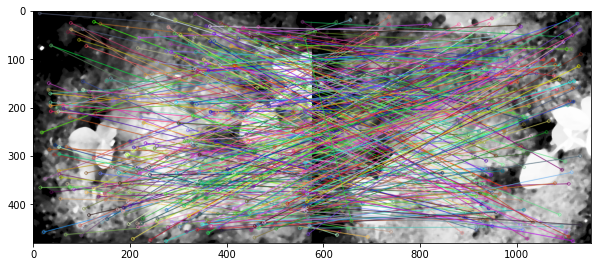

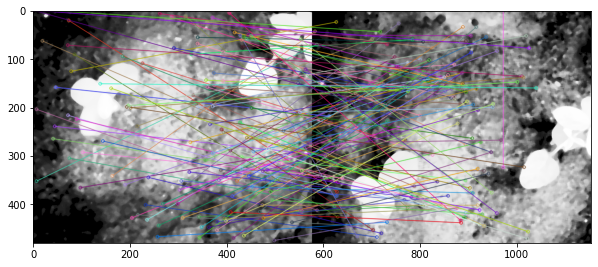

In [47]:


# Selecionar as imagens que vão ser alinhadas:
def stitch_SIFT(img_original, base, visualize = True):

    if (len(base.shape) > 2):
        gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    else:
        gray = base
        
    img =  equalize_smooth(img_original)
    gray = equalize_smooth(base)   

    # Seleção dos descriptors:
    descriptor = cv2.SIFT.create()
    # descriptor = cv2.xfeatures2d.SURF_create() #O SURF não é um algoritmo open source e só é incluido no opencv-contrib-python use com cautela.
    matcher = cv2.FlannBasedMatcher()

    # get features from images
    kps_img, desc_img = descriptor.detectAndCompute(img, mask=None)

        
    kps_base, desc_base = descriptor.detectAndCompute(gray, mask=None)

    # find the corresponding point pairs
    if (desc_img is not None and desc_base is not None and len(desc_img) >=2 and len(desc_base) >= 2):
        rawMatch = matcher.knnMatch(desc_base, desc_img, k=2)

    matches = []
    # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    ratio = 0.75
    for m in rawMatch:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            # print("Train index: ", m[0].trainIdx, "\n Query index", m[0].queryIdx)
            # print()
            
    if visualize:
        # Apply ratio test
        good = []
        for m,n in rawMatch:
            if m.distance < 0.75*n.distance:
                good.append([m])
        img3 = cv2.drawMatchesKnn(img,kps_img,gray,kps_base,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        fig, ax = plt.subplots( figsize = (10,5))
        ax.imshow(img3)
        plt.show()
        

    # convert keypoints to points
    pts_img, pts_base = [], []
    for id_img, id_base in matches:
        pts_img.append(kps_img[id_img].pt)
        pts_base.append(kps_base[id_base].pt)
    pts_img = np.array(pts_img, dtype=np.float32)
    pts_base = np.array(pts_base, dtype=np.float32)

    # compute homography
    if len(matches) > 4:
    #     H, status = cv2.findHomography(pts_img, pts_base, cv2.RANSAC)
        H, _ = cv2.estimateAffine2D(pts_img, pts_base)
        H = np.vstack((H, [0, 0, 1]))
        # print("H = ", H)
    warped = cv2.warpPerspective(img_original, H, (base.shape[1], base.shape[0]))
    return warped

base = G
warped = stitch_SIFT(R, base)
warped = stitch_SIFT(IR, base)


In [29]:
# visualize the result
winname = 'result'
cv2.namedWindow(winname, cv2.WINDOW_KEEPRATIO)
alpha = 5
# res = cv2.addWeighted(base, 0.5, warped, 0.5, 0)
res = None
def onChange(alpha):
    global base, warped, res, winname
    res = cv2.addWeighted(base, alpha/5, warped, 1 - alpha/5, 0)
    cv2.imshow(winname, res)
    cv2.imwrite("alignmentR"+ str(alpha) + ".png",res) # Salva as imagens mostradas pelo trackbar

onChange(alpha)
cv2.createTrackbar('alpha', winname, alpha, 5, onChange)
cv2.imshow(winname, res)

cv2.waitKey()
cv2.destroyAllWindows()

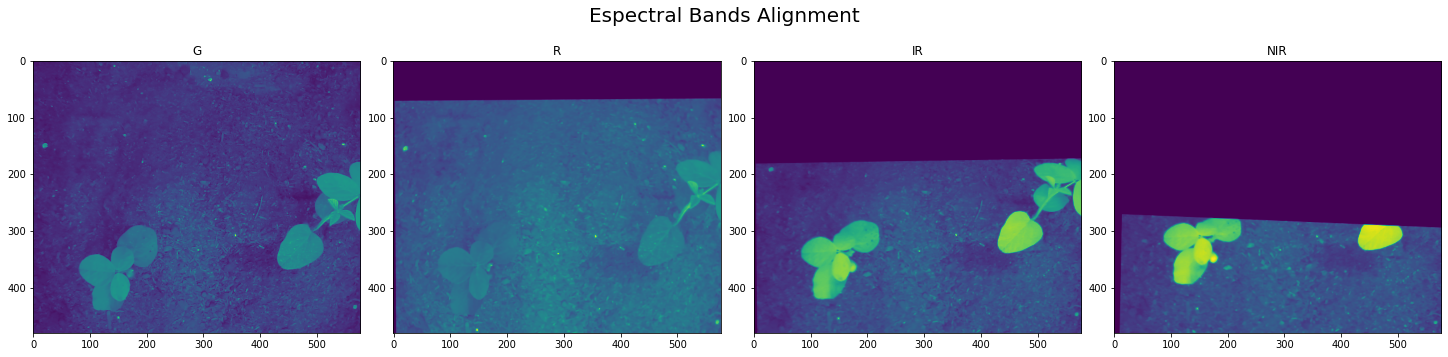

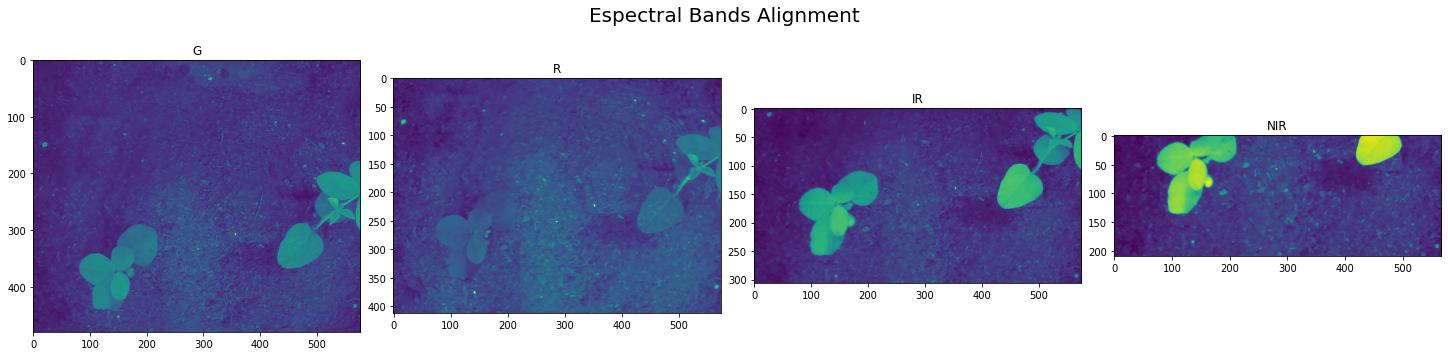

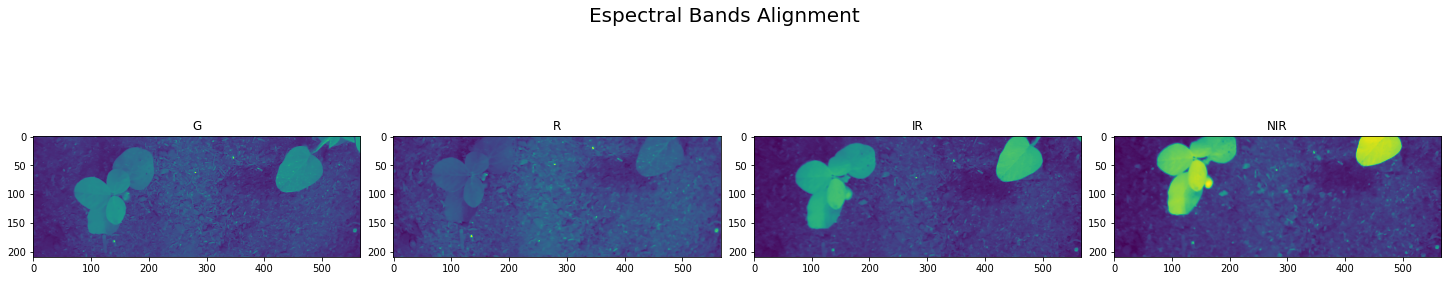

In [48]:
# Visualização da sobreposição para cada banda
base = G
bands_dict = dict()
spectral_img = []
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)

for (img, ax, name) in zip(bands, axs, names):
    warped = stitch_SIFT(img,base, False)
    bands_dict[name] = warped 
    ax.imshow(warped)
    ax.set_title(name)
    x, y, w, h  = cv2.boundingRect(cv2.findNonZero(warped))
#     print(x, y, w, h)
    rect = img[:h, :w] 
    spectral_img.append(rect)
plt.show()

fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)
for (img, ax, name) in zip(spectral_img, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)

spectral_dict = dict()
x, y, w, h  = cv2.boundingRect(cv2.findNonZero(bands_dict["NIR"]))
for (img, ax, name) in zip(spectral_img, axs, names):
    ax.imshow(img[-h:, -w:] )
    spectral_dict[name] = img[-h:, -w:]
    ax.set_title(name)
#     print(x, y, w, h)
plt.show()



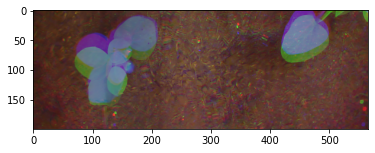

In [26]:
merged = cv2.merge([spectral_dict["R"], spectral_dict["G"], spectral_dict["IR"]])
plt.imshow(merged)
plt.show()


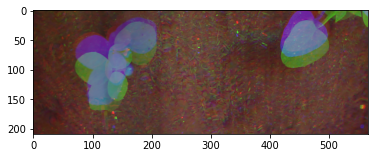

In [49]:
merged = cv2.merge([spectral_dict["R"], spectral_dict["G"], spectral_dict["IR"]])
plt.imshow(merged)
plt.show()